# Online Learning with Many Experts

[RWMA]:https://en.wikipedia.org/wiki/Randomized_weighted_majority_algorithm
[WMA]:https://en.wikipedia.org/wiki/Weighted_majority_algorithm_(machine_learning)
[OLME]:https://arxiv.org/pdf/1702.07870.pdf

This notebook aims to implement algorithm 2 of [Online Learning with Many Experts][OLME], by A. Cohen and S. Mannor, 2017.

- *Background*  
[Randomized weighted majority algorithm][RWMA] and [Weighted majority algorithm][WMA] are algorithms that pool predictions from different experts (without prior knowledge regarding their respective accuracy) and construct a prediction decision. As time goes by, the experts' voting weights are modified depending on their past performance. The final decision aims to minimize expected regret, defined as the difference between the algorithm cumulative loss and the cumulative loss given by the best expert in hindsight. The difference between RWMA and WMA is that RWMA chooses a random expert using weights as a probability distribution, while WMA is the weighted vote of experts. Throughout this notebook, both algorithms are used.

- *Initial problem*  
Both RWMA and WMA have expected regret increasing with the number of experts. This can become an issue in problems with many experts.

- *Solution proposed by the authors*  
Cohen and Mannor try to create a group of representative experts. They do so online: each time an expert has loss that is very different to others', it is added to the group. Only the experts belonging to the group are allowed to vote. Thus the number of experts only depends on what "different to others" means. Cohen and Mannor use concept of $\epsilon$-covering of the loss-function space: at any point in time, if an expert's loss is more than $2\epsilon$ away from all others expert losses, the expert is added to the group.

Notation is kept similar to the paper's.

In [1]:
from sklearn.linear_model import ElasticNet
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
T = 200  # Number of observations
N = 5000  # Number of good and bad experts. i.e. there are 2*N experts total.

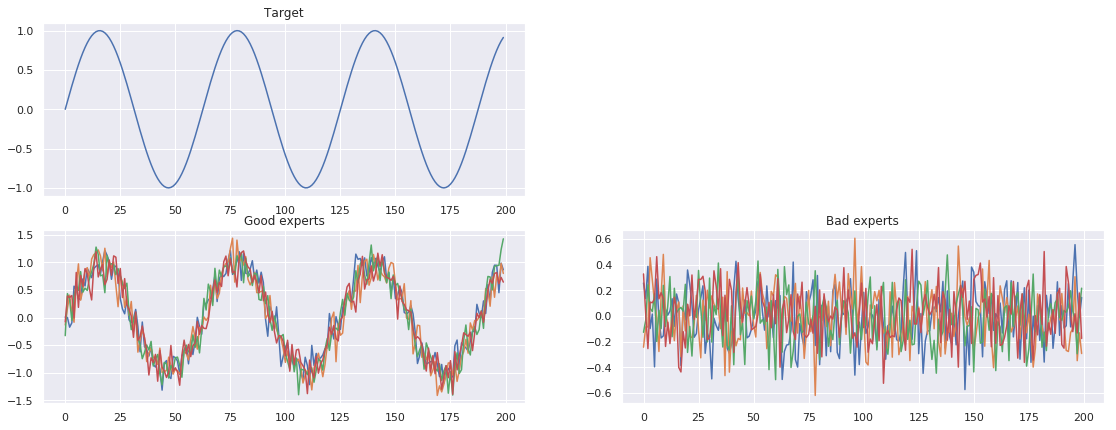

In [3]:
noise = 0.2  # How noisy experts are

target = np.sin(np.linspace(0,20,T))
good_experts = target + np.random.normal(scale=noise, size=(N,T))
bad_experts = np.random.normal(scale=noise, size=(N,T))
all_experts = np.concatenate((good_experts, bad_experts))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(19,7))
ax1.plot(target)
ax1.set_title('Target')
ax3.plot(good_experts[:4,:].T);
ax3.set_title('Good experts')
ax4.plot(bad_experts[:4,:].T);
ax4.set_title('Bad experts');
f.delaxes(ax2);

In [4]:
def get_gamma(t, K):
    """
    Get the theoretically optimal gamma
    t: time-index of the round
    K: nb of experts voting that round
    """
    if t == 0 :
        return 0
    return np.sqrt(8 * np.log(K) / t)

# WMA and RWMA

[RWMA]:https://en.wikipedia.org/wiki/Randomized_weighted_majority_algorithm
[WMA]:https://en.wikipedia.org/wiki/Weighted_majority_algorithm_(machine_learning)

We first run the basic [RWMA][RWMA] and [WMA][WMA] algorithms.

## Algorithm

In [5]:
def get_rwma_wma(target, experts, ret_losses_n_weights=True):
    if ret_losses_n_weights:
        all_losses = []
        all_weights = []
    wma = []
    rwma = []
    
    weights_t = np.ones(shape=2*N) / 2*N

    for t in tqdm(range(T)):
        predictions_t = experts[:,t]
        loss_t = (predictions_t - target[t])**2
        gamma_t = get_gamma(t, 2*N)
        weights_t = weights_t * np.exp(-gamma_t * loss_t)
        weights_t = weights_t / weights_t.sum()  # scale em

        wma.append(np.dot(weights_t, predictions_t))
        rwma.append(np.random.choice(predictions_t, p=weights_t))

        if ret_losses_n_weights: # log them
            all_losses.append(loss_t)
            all_weights.append(weights_t)
            
    if ret_losses_n_weights:
        return rwma, wma, all_losses, all_weights
    return rwma, wma

In [6]:
rwma, wma, all_losses, all_weights = get_rwma_wma(target, all_experts)

100%|██████████| 200/200 [00:00<00:00, 1491.80it/s]


## Results

We now show the predictions from both algorithms.

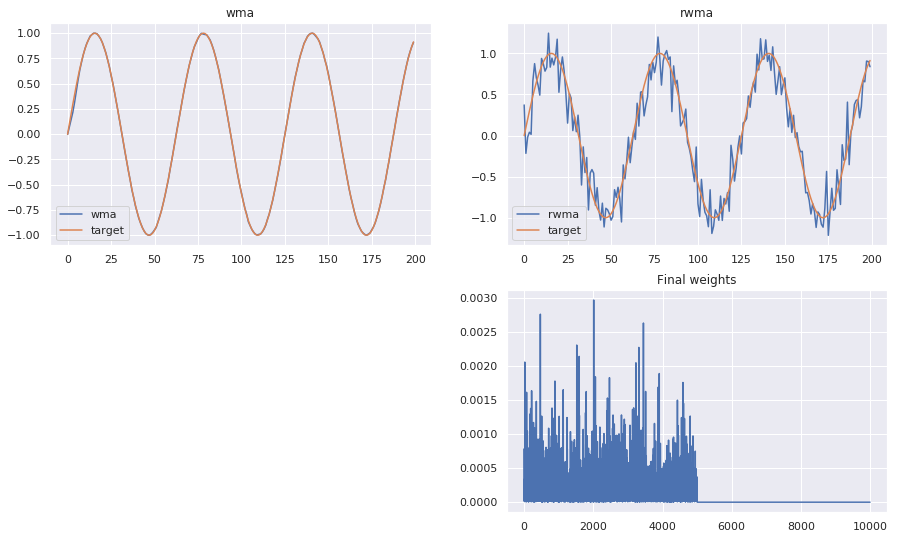

In [7]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,9))
ax1.plot(wma, label='wma')
ax1.plot(target, label='target')
ax1.set_title('wma')
ax1.legend()
ax2.plot(rwma, label='rwma')
ax2.plot(target, label='target')
ax2.set_title('rwma')
ax2.legend()
ax4.plot(all_weights[-1])
ax4.set_title('Final weights')
f.delaxes(ax3)

As one might expect, both algorithms predict well the general trend of the target but the RWMA predictino jumps around it quite a bit.

The difference between good and bad experts clearly materializes in the histograms of final weights. However, even though the good experts' predictions are coming from the same distribution, their final weights are far from being uniformly distributed.

# Online ElasticNet comparison

To understand our preliminary results better, we here give results from an online ElasticNet (l1 and l2 regularization on a linear regression). At each time $t$, we run the ElascticNet on all data since $t=0$.

In [8]:
online_en = []  # Stores the predictions
alpha = 100  # Regularization coefficient
l1_ratio = 0.00001  # Weight of l1 regularization vs l2
starting_point = 2  # To avoid regressing on an empty set

for t in tqdm(range(starting_point,T)):
    experts_subset = all_experts[:, :t]  # Experts predictions until t
    target_subset = target[:t]  # Target until t
    
    reg = ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(X=experts_subset.T, y=target_subset.reshape(-1,1))
    pred = reg.predict(experts_subset.T)
    
    online_en.append(pred[-1]) 

100%|██████████| 198/198 [01:56<00:00,  1.12s/it]


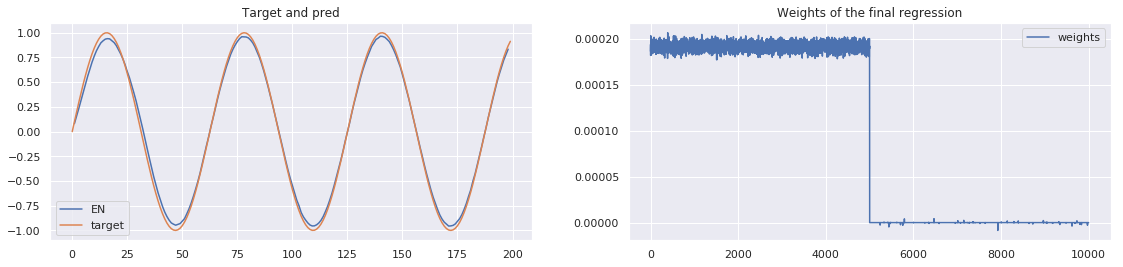

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19,4))
ax1.plot([np.nan]*(starting_point-1) + online_en, label='EN')
ax1.plot(target, label='target')
ax1.set_title('Target and pred')
ax1.legend()
ax2.plot(reg.coef_, label='weights')
ax2.set_title('Weights of the final regression')
ax2.legend();

Results are seducing: predictions are close to the target and same-expert weights are almost uniformly distributed.  
However, due to the computation complexity, the online ElasticNet cannot be ran on many data points and/or experts in practice. Even if we roll the regression window to limit this issue, we would still have to tune the regularization parameters alpha and l1_ratio, which adds complexity.

# Online Learning with Many Experts

## $\epsilon$-covering

*Definition: Epsilon-covering* 

An $\epsilon$-covering at time $t$, noted $S_t$, is a subset of K experts such that:
$$\forall\: \text{expert}_j \notin S_t, \: \exists\: \text{expert}_i \in S\: \text{such that} \:|l_t(expert_i) - l_t(expert_j)| \lt \epsilon$$

For a lengthier explanation, Cohen and Manner refer to Packing and covering by Rogers (1964).

In [10]:
def get_covering(current_covering, losses, epsilon=0.01):

    experts_not_in_S = set(np.arange(losses.shape[0])) - set(current_covering)

    for j in experts_not_in_S:

        covered_by_S = False
        
        for i in current_covering:
            loss_difference = abs(losses[i]-losses[j])
            if loss_difference < 2*epsilon:
                covered_by_S = True
                break

        if not covered_by_S:
            current_covering.append(j)   
            
    return current_covering

We fix an epsilon and plot the corresponding $\epsilon$-covering in the loss function space at $t=T$. This allows us to get a better intuition as to what epsilon should be. Note that the final covering will be different, since experts are added to the covering online throughout time (and never removed from it). 

The plot is an histogram of the losses at $t=T$. The red vertical bars correspond to the final loss of the experts in the $\epsilon$-covering at time $t=T$.

Final number of experts in S: K=5


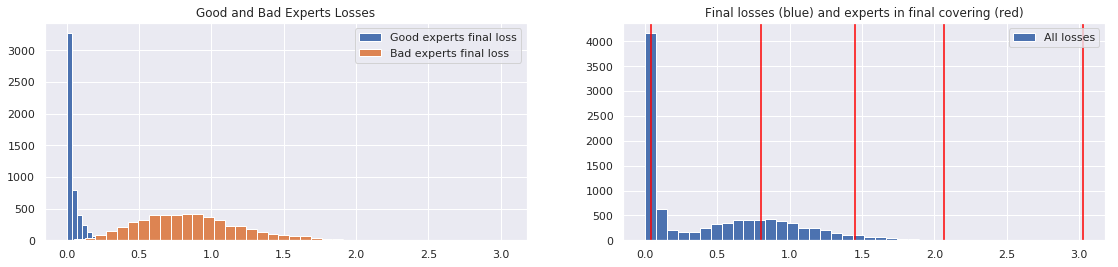

In [11]:
final_covering = get_covering([np.random.randint(N)], all_losses[-1], epsilon=0.3)
good_experts_final_loss = all_losses[-1][:N]
bad_experts_final_loss = all_losses[-1][N:]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19,4))
ax1.hist(good_experts_final_loss, label='Good experts final loss', bins=15)
ax1.hist(bad_experts_final_loss, label='Bad experts final loss', bins=40)
ax1.set_title('Good and Bad Experts Losses')
ax1.legend()

print('Final number of experts in S: K={}'.format(len(final_covering)))
ax2.hist(all_losses[-1], bins=40, label='All losses')
for i in final_covering:
    ax2.axvline(all_losses[-1][i], c='red')
ax2.set_title('Final losses (blue) and experts in final covering (red)')
ax2.legend();

We potentially have an issue here: good experts losses are very similar, while bad experts losses have more variance. While the result above is only a point-in-time snapshot of losses, it could mean that the $\epsilon$-covering could be composed mainly of bad experts.

## The OLME algorithm

We now code the algorithm presented in the paper.

In [12]:
def get_olme(target, experts, epsilon=1.0, ret_all_info=True):
    tau = 0
    olme_wma = []
    olme_rwma = []
    K = [1]
    weights_t = [1]
    coverings = [[np.random.randint(N)]]  # Initial random e-covering
    
    if ret_all_info:
        all_losses = []
        all_weights = []

    for t in tqdm(range(T)):
        predictions_t = experts[:,t]
        loss_t = (predictions_t - target[t])**2
        coverings.append(get_covering(coverings[-1].copy(), loss_t, epsilon))
        K.append(len(coverings[-1]))

        if K[-1] != K[-2]:  # if experts are added to the epsilon-covering
            tau = t
            weights_t = np.ones(shape=K[-1]) / K[-1]
        else:
            gamma_t = get_gamma(t-tau, K[-1])
            weights_t = weights_t * np.exp(-gamma_t * loss_t[coverings[-1]])
            weights_t = weights_t / weights_t.sum()  # scale the weights

        predictions_s = predictions_t[coverings[-1]]
        olme_wma.append(np.dot(weights_t, predictions_s))
        olme_rwma.append(np.random.choice(predictions_s, p=weights_t))
        
        if ret_all_info:
            all_losses.append(loss_t)
            all_weights.append(weights_t)
            
    if ret_all_info:
        return olme_rwma, olme_wma, all_losses, all_weights, K, coverings
    return olme_rwma, olme_wma    

In [13]:
olme_rwma, olme_wma, all_losses, all_weights, K, coverings = get_olme(target, all_experts)

100%|██████████| 200/200 [00:01<00:00, 152.22it/s]


# Results

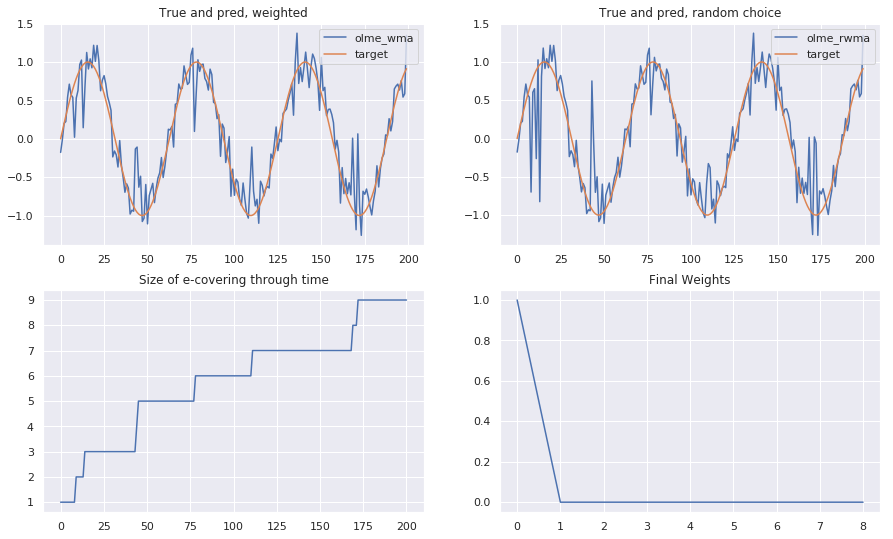

In [14]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,9))
ax1.plot(olme_wma, label='olme_wma')
ax1.plot(target, label='target')
ax1.set_title('True and pred, weighted')
ax1.legend()
ax2.plot(olme_rwma, label='olme_rwma')
ax2.plot(target, label='target')
ax2.set_title('True and pred, random choice')
ax2.legend()
ax3.plot(K)
ax3.set_title('Size of e-covering through time')
ax4.plot(all_weights[-1])
ax4.set_title('Final Weights');

In [15]:
print('Covering at t=T:\n {}'.format(coverings[-1]))

Covering at t=T:
 [3386, 5947, 5770, 8065, 8410, 6106, 8296, 7730, 9153]


The final prediction of OLME follows the target. However, it does not do so as closely as the RWMA or WMA above. This is partly explained by the fact that OLME keeps adding experts throughout time and resets weights when it does. This causes bad experts to weigh more in the final decision. 

As previously feared, the $\epsilon$ covering is composed mainly of bad experts: only one (out of nine) expert in the final covering is a good one!

These results reinforce the idea that OLME is better used in cases with more diverse experts, and overall more experts.

# Next Steps

* I will implement the automatic search for $\epsilon$, as Cohen and Mannor describe it in section 4 of their paper.
* Is $\epsilon$-covering the best way to create the representative group? In every time-period, for every expert, we have a feature vector containing all losses since $t=0$. We can cluster the experts online in a different way than proposed in the paper. 

Coming soon.